# A multi-layer neural network for multi-label classification

#### First, we have to import some packages and initialize som data for training the network:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
import random

In [8]:
from sklearn.datasets import make_blobs
X, t = make_blobs(n_samples=[400,800,400], centers=[[0,0],[1,2],[2,3]], 
                  n_features=2, random_state=2019)

In [9]:
indices = np.arange(X.shape[0])
random.seed(2020)
random.shuffle(indices)
indices[:10]

array([1301,  293,  968,  624,  658,  574,  433,  368,  512,  353])

In [10]:
X_train = X[indices[:800],:]
X_val = X[indices[800:1200],:]
X_test = X[indices[1200:],:]
t_train = t[indices[:800]]
t_val = t[indices[800:1200]]
t_test = t[indices[1200:]]

In [11]:
t2_train = t_train == 1
t2_train = t2_train.astype('int')
t2_val = (t_val == 1).astype('int')
t2_test = (t_test == 1).astype('int')

In [12]:
def show(X, y, marker='.'):
    labels = set(y)
    for lab in labels:
        plt.plot(X[y == lab][:, 1], X[y == lab][:, 0],
                 marker, label="class {}".format(lab))
    plt.legend()

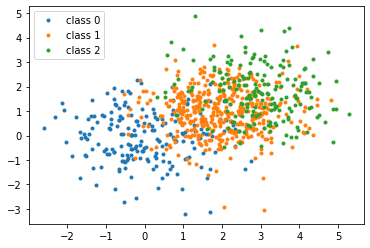

In [13]:
show(X_train, t_train)

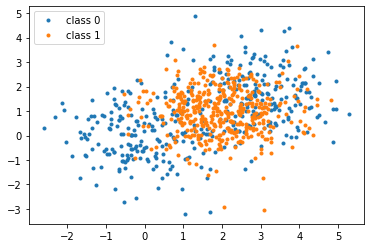

In [14]:
show(X_train, t2_train)

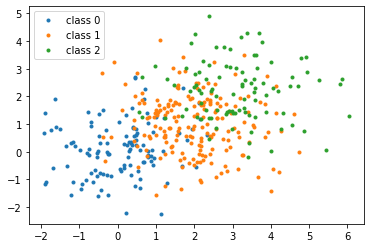

In [15]:
show(X_val, t_val)

### Before we implement the algorithm, some useful methods should be defined:

In [33]:
#Useful methods for the implementation
def mmScaler(X): #column wise max/min scaling
    x = X.copy()
    for i in range(x.shape[1]):
        p = x[:, i]
        x[:, i] = (p - p.min()) / (p.max() - p.min())
    return x

def oneVSall(t_train): #Transforming targets from integer respresentation to one-vs-all representation in 2D matrix
        if type(t_train) is np.ndarray:
            t_train = t_train.tolist()
            maxes = int(np.max(t_train))
        out = np.zeros((len(t_train),maxes+1))
        for i in range(len(t_train)):
            out[i][t_train[i]] = 1
        return out
    
def randomWeights(W, m): #return 2D array like W with small random scalars defined by m.
    w = W.copy()
    for i in range(w.shape[0]):
        for x in range(w.shape[1]):
            w[i][x] = random.uniform(-1,1)*(1/np.sqrt(m))
    return w

def add_bias(X): # Put bias of 1 in position 0
    sh = X.shape
    if len(sh) == 1:
        #X is a vector
        return np.concatenate([np.array([1]), X])
    else:
        # X is a matrix
        m = sh[0]
        bias = np.ones((m,1)) # Makes a m*1 matrix of 1-s
        return np.concatenate([bias, X], axis  = 1)

def nolinear(X): # to add the three non-linear features to the X-data.
    non_linear = X.copy()
    new_row1 = (np.square(non_linear[:,0])).reshape(-1,1)
    new_row2 = np.square(non_linear[:,1]).reshape(-1,1)
    new_row3 = (non_linear[:,0] * non_linear[:,1]).reshape(-1,1)
    non_linear = np.hstack((non_linear, new_row1, new_row2, new_row3))
    return non_linear
    
def g(x):
    return 1/(1+np.exp(-x)) #logistic activation function


## Implementation of the MNN classifier:

In [31]:
class MNNClassifier():
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self,eta = 0.001, dim_hidden = 6):
        """Initialize the hyperparameters"""
        self.eta = eta
        self.dim_hidden = dim_hidden
        
    def fit(self, X_train, t_train, epochs = 1000, batch = False, batch_size = 20):
        """Training phase: initialization of weights, train for *epochs* with batch size of choice"""
        
        # Initilaization:
        self.X_train = mmScaler(X_train)      #Scaling X
        self.t_train = oneVSall(t_train)      #transforming t_train to one-vsall shape
        dim_in = X_train.shape[1]
        dim_out = self.t_train.shape[1]
        
        weights11 = np.ones((dim_in+1, self.dim_hidden)) #Initiate weights in right shape
        self.weights1 = randomWeights(weights11, dim_in) #give the wights random low values

        weights22 = np.ones((self.dim_hidden+1, dim_out)) #Initiate weights in right shape
        self.weights2 = randomWeights(weights22, dim_in)  #give the wights random low values
        
        for e in range(epochs):
            
            #If batch is true: apply mini-batch stochastic descent
            if batch:
                self.X_train, self.t_train = self.batchSample(self.X_train, self.t_train, batch_size)
            
            #Forward:
            hidden_activations, output_activations = self.forward(self.X_train)
            
            #Backward
            update1, update2 = self.backward(output_activations, hidden_activations)
            self.weights1 +=update1
            self.weights2 +=update2
            
    def forward(self, X_train):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        hidden_activations = g(add_bias(X_train)@self.weights1)
        output_activations = g(add_bias(hidden_activations)@self.weights2)
        return hidden_activations, output_activations
        
    def backward(self, output_activations, hidden_activations):
        """Perform backpropegation and return the updates which are
        to be added to the weights """
        delta_output = (self.t_train - output_activations) * output_activations * (1.0 - output_activations)
        delta_hidden = hidden_activations * (1.0 - hidden_activations) * (delta_output @ self.weights2.T[:,:-1])
        
        update1 = self.eta * (add_bias(self.X_train).T @ delta_hidden)
        update2 = self.eta * (add_bias(hidden_activations).T @ delta_output)
        return update1, update2
    
    def batchSample(self, X_train, t_train, batch_size=20):
        batch = (np.array(random.sample(range(t_train.shape[0]), batch_size)))
        t_retur = t_train[batch]
        X_retur = X_train[batch]
        return X_retur, t_retur
    
    def accuracy(self, X_test, t_test):
        """Calculates the accuracy of the classifier for (X_test, t_test)"""
        y = self.predict(X_test)
        correct = (t_test == y).sum()
        accuracy = correct/(len(y))
        return accuracy
    
    def confusionMatrix(self, X_test, t_test):
        """Calculates the confusion matrix, accuracy, presicion and
        recall of the classifier for the pair (X_test, t_test).
        In the p_matrix: accuracy is the first index, predicted
        labels is the left collumn and targets labels in top row."""
        y_pred = self.predict(X_test)
        t_argets = t_test
        classes = np.unique(t_argets)
        correct = (y_pred == t_argets).sum()
        accuracy = correct/(len(y_pred))
        true_p = np.array(classes)
        matrix = np.zeros((classes.shape[0],classes.shape[0]))
        for i in range(len(classes)):
            true_p[i] = ((y_pred == classes[i])&(t_argets == classes[i])).sum()
            for e in range(len(classes)):
                matrix[i,e] = ((y_pred == classes[i]) & (t_argets == classes[e])).sum()
        p_matrix = np.hstack(((np.hstack(([round(accuracy,2)],classes)).reshape(-1,1)),(np.vstack((classes, matrix))))) #Adding labels to matrix
        presicion = (true_p/matrix.sum(axis=1)).reshape(-1,1) #presicion = tp/tp+fp for each class
        recall = (true_p/matrix.sum(axis=0))         #recall = tp/tp+fn for each class
        return p_matrix, accuracy, presicion, recall
        
    def predict(self, X_pred):
        X_pred = mmScaler(X_pred)     #Scaling the input data
        h, y = self.forward(X_pred)
        result = np.argmax(y, axis=1) #Transforming result from one-vs-all to scalar representation
        return result

## Experiment:

In [29]:
#Without mini-batch:
for e in [8, 25, 50, 100, 150, 300, 500, 1000, 10000,100000]:
    network = MNNClassifier(eta = 0.01, dim_hidden = 6)
    network.fit(X_train, t_train, epochs = e)
    print("Epochs: {} Accuracy: {}".format(
        e, network.accuracy(X_val, t_val)))

Epochs: 8 Accuracy: 0.4725
Epochs: 25 Accuracy: 0.4725
Epochs: 50 Accuracy: 0.4725
Epochs: 100 Accuracy: 0.4725
Epochs: 150 Accuracy: 0.67
Epochs: 300 Accuracy: 0.58
Epochs: 500 Accuracy: 0.6325
Epochs: 1000 Accuracy: 0.5975
Epochs: 10000 Accuracy: 0.685
Epochs: 100000 Accuracy: 0.6925


In [30]:
#With baches of various sizes:
for e in [10, 15, 25, 50, 70, 85, 100, 150, 200, 300, 500]:
    network = MNNClassifier(eta = 0.01, dim_hidden = 7)
    network.fit(X_train, t_train, epochs = 10000, batch = True, batch_size = e)
    print("Batch Size: {} Accuracy: {}".format(
        e, network.accuracy(X_val, t_val)))

Batch Size: 10 Accuracy: 0.4725
Batch Size: 15 Accuracy: 0.425
Batch Size: 25 Accuracy: 0.495
Batch Size: 50 Accuracy: 0.65
Batch Size: 70 Accuracy: 0.5425
Batch Size: 85 Accuracy: 0.72
Batch Size: 100 Accuracy: 0.73
Batch Size: 150 Accuracy: 0.6775
Batch Size: 200 Accuracy: 0.6325
Batch Size: 300 Accuracy: 0.66
Batch Size: 500 Accuracy: 0.6725


In [26]:
#Multilayer neural network on multiclass classification:
network3 = MNNClassifier(eta = 0.01, dim_hidden = 7)
network3.fit(X_train, t_train, epochs = 10000, batch = True, batch_size = 150)
print("Correct labels in first row, predicted labels in first collumn and accuracy in first index:")
print(network3.confusionMatrix(X_test, t_test)[0])
print("Presicion for each of the classes:")
print(network3.confusionMatrix(X_test, t_test)[2])
print("Recall for for each of the predicted classes:")
print(network3.confusionMatrix(X_test, t_test)[3])

Correct labels in first row, predicted labels in first collumn and accuracy in first index:
[[  0.76   0.     1.     2.  ]
 [  0.    72.    13.     0.  ]
 [  1.    20.   148.    31.  ]
 [  2.     0.    34.    82.  ]]
Presicion for each of the classes:
[[0.84705882]
 [0.74371859]
 [0.70689655]]
Recall for for each of the predicted classes:
[0.7826087  0.75897436 0.72566372]


In [27]:
#Multilayer neural network on binary classification:
network3 = MNNClassifier(eta = 0.01, dim_hidden = 7)
network3.fit(X_train, t2_train, epochs = 10000, batch = True, batch_size = 150)
print("Correct labels in first row, predicted labels in first collumn and accuracy in first index:")
print(network3.confusionMatrix(X_test, t2_test)[0])
print("Presicion for each of the classes:")
print(network3.confusionMatrix(X_test, t2_test)[2])
print("Recall for for each of the predicted classes:")
print(network3.confusionMatrix(X_test, t2_test)[3])

Correct labels in first row, predicted labels in first collumn and accuracy in first index:
[[  0.64   0.     1.  ]
 [  0.    69.     7.  ]
 [  1.   136.   188.  ]]
Presicion for each of the classes:
[[0.90789474]
 [0.58024691]]
Recall for for each of the predicted classes:
[0.33658537 0.96410256]


In [28]:
#Multilayer neural network with non-linear features on multiclass classification:
network3 = MNNClassifier(eta = 0.01, dim_hidden = 7)
network3.fit(nolinear(X_train), t_train, epochs = 10000, batch = True, batch_size = 150)
print("Correct labels in first row, predicted labels in first collumn and accuracy in first index:")
print(network3.confusionMatrix(nolinear(X_test), t_test)[0])
print("Presicion for each of the classes:")
print(network3.confusionMatrix(nolinear(X_test), t_test)[2])
print("Recall for for each of the predicted classes:")
print(network3.confusionMatrix(nolinear(X_test), t_test)[3])

Correct labels in first row, predicted labels in first collumn and accuracy in first index:
[[  0.76   0.     1.     2.  ]
 [  0.    61.     4.     0.  ]
 [  1.    31.   168.    37.  ]
 [  2.     0.    23.    76.  ]]
Presicion for each of the classes:
[[0.93846154]
 [0.71186441]
 [0.76767677]]
Recall for for each of the predicted classes:
[0.66304348 0.86153846 0.67256637]


## End of experiment

For all three tasks, the accuracy was above 0.75 which is not too bad considering that the data is far from linear seperable. Presicion is consequently slightly better for class 0 than the other classes, whereas recall is more even between the classes. As can be seen on the matrixes for the class tasks, it is more common for the network to mistake 1s and 0s, and 2s and 1s than 0s and 2s. This can easily be explained by looking at the distribution of the classes where 0 and 1 overlap and 1 and 2 overlap:

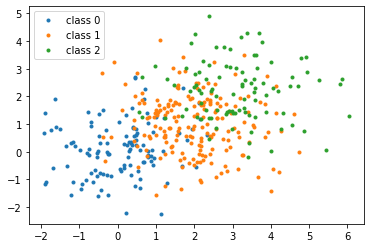

In [32]:
show(X_val, t_val)

## End of document